In [2]:
import dask
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from glob import glob
import os
import gc

gc.collect()

# Configurar Dask
dask.config.set({"dataframe.convert-string": False})
client = Client()

# Paths locales
train_path = '/home/stargix/Desktop/hackathons/datathon/train/train'
test_path = '/home/stargix/Desktop/hackathons/datathon/test/test'

/home/stargix/Desktop/hackathons/datathon/.venv/lib/python3.10/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44659 instead
  warnings.warn(


In [3]:
# Definir TODAS las columnas necesarias (basado en tu lista)
required_columns = [
    'row_id', 'datetime',  # Identificadores y tiempo
    # Target variables
    'buyer_d7', 'iap_revenue_d7',
    # Categorical features principales
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 
    'advertiser_bottom_taxonomy_level',
    'country', 'region',
    'dev_make', 'dev_model', 'dev_os', 'dev_osv',
    'carrier',
    # Temporal features
    'hour', 'weekday', 'weekend_ratio', 'hour_ratio',
    'release_date', 'release_msrp',
    # User behavior features
    'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration',
    'weeks_since_first_seen', 'wifi_ratio',
    # Retention
    'retentiond7',
    # Historical features
    'city_hist', 'country_hist', 'region_hist', 'dev_language_hist', 'dev_osv_hist',
    # Ad performance
    'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk',
    # Revenue/buy related (NO targets)
    'iap_revenue_usd_bundle', 'iap_revenue_usd_category',
    'num_buys_bundle', 'num_buys_category',
    'last_buy', 'last_ins',
    # Bundle/Category info
    'bcat', 'bcat_bottom_taxonomy',
    'bundles_cat', 'bundles_cat_bottom_taxonomy', 
    'bundles_ins',
    'new_bundles', 'user_bundles', 'user_bundles_l28d',
    # Advertiser/User actions
    'advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_count', 'user_actions_bundles_action_last_timestamp',
    'last_advertiser_action',
    # First request info
    'first_request_ts', 'first_request_ts_bundle', 
    'first_request_ts_category_bottom_taxonomy',
    # Ranking features
    'rwd_prank',
    'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank'
]

# Cargar datos con Dask (solo 5% de los archivos)
parquet_files_train = glob(os.path.join(train_path, '**/part-*.parquet'), recursive=True)
num_files_train = max(1, int(len(parquet_files_train) * 0.1))
parquet_files_train = parquet_files_train[:num_files_train]

# Intentar cargar solo columnas que existan
try:
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow', columns=required_columns)
    print(f"✓ Train cargado con {num_files_train} archivos (5% del total)")
    print(f"✓ Columnas cargadas: {len(required_columns)}")
except Exception as e:
    # Si alguna columna no existe, cargar todas
    print(f"⚠️ Error cargando columnas específicas: {e}")
    print("Cargando TODAS las columnas disponibles...")
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow')
    print(f"✓ Train cargado con {num_files_train} archivos")
    print(f"✓ Columnas disponibles: {len(train_ddf.columns)}")

✓ Train cargado con 14 archivos (5% del total)
✓ Columnas cargadas: 62


In [4]:
# Exploración básica
train_sample = train_ddf.head(10)
print(f"Train columns: {train_ddf.columns.tolist()}")
display(train_sample.head())

Train columns: ['row_id', 'datetime', 'buyer_d7', 'iap_revenue_d7', 'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'advertiser_bottom_taxonomy_level', 'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv', 'carrier', 'hour', 'weekday', 'weekend_ratio', 'hour_ratio', 'release_date', 'release_msrp', 'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration', 'weeks_since_first_seen', 'wifi_ratio', 'retentiond7', 'city_hist', 'country_hist', 'region_hist', 'dev_language_hist', 'dev_osv_hist', 'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk', 'iap_revenue_usd_bundle', 'iap_revenue_usd_category', 'num_buys_bundle', 'num_buys_category', 'last_buy', 'last_ins', 'bcat', 'bcat_bottom_taxonomy', 'bundles_cat', 'bundles_cat_bottom_taxonomy', 'bundles_ins', 'new_bundles', 'user_bundles', 'user_bundles_l28d', 'advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp', 'user_actions_bundles_action_count', 'user_actions_bundles_action_last_times

,row_id,datetime,buyer_d7,iap_revenue_d7,advertiser_bundle,advertiser_category,advertiser_subcategory,advertiser_bottom_taxonomy_level,country,region,...,advertiser_actions_action_last_timestamp,user_actions_bundles_action_count,user_actions_bundles_action_last_timestamp,last_advertiser_action,first_request_ts,first_request_ts_bundle,first_request_ts_category_bottom_taxonomy,rwd_prank,whale_users_bundle_num_buys_prank,whale_users_bundle_revenue_prank
0,21aa9ec2-9b8c-4398-9e77-cff1034c5494,2025-10-01-05-00,0,0.0,ff9bdd5dc427114eef1c6372526548e01a5ef45d,finance,finance,investing & financial management (general),ae,None,...,None,None,None,None,NaN,None,None,None,None,None
1,845496a4-e905-4293-9f7b-94ffbe9025f7,2025-10-01-05-00,0,0.0,7eaeef21e215654ea75a5ef78692d1f8ffd0ca54,sport betting,unknown,None,ci,None,...,None,None,None,None,NaN,None,None,None,None,None
2,02c31d46-1d66-4350-94c1-c25aeca95c2f,2025-10-01-05-00,0,0.0,7eaeef21e215654ea75a5ef78692d1f8ffd0ca54,sport betting,unknown,None,eg,None,...,None,None,None,None,NaN,None,None,None,None,None
3,364349a9-51f1-4da7-bd4b-a9d66593af9b,2025-10-01-05-00,0,0.0,a0c967be5df05b67a80b700bb0a0742904b6f8cd,game,casino,slots,mx,None,...,None,"[(366cc2284511794d657dad6ad60cf15eeabeca20, [(...","[(366cc2284511794d657dad6ad60cf15eeabeca20, [(...",None,1.759190e+09,"[(c77c028847c7d527a3f40c089a5f342c6fdc650d, 17...","[(Music & Podcasts (General), 1758499200), (Bu...","[(64876421d6b1a60f1c4449aefbdc54e316df1402, 0....",None,None
4,14a44ece-84c6-4884-a78a-6b05ad55e3e5,2025-10-01-05-00,0,0.0,001b729f996da29d01e9e3641ac7fb153e6bc98e,game,casual,match swap,pk,None,...,None,"[(cd9b2558bcf52078c64242e751017419651181d9, [(...","[(cd9b2558bcf52078c64242e751017419651181d9, [(...",None,1.759190e+09,"[(9c1e37d232525005746273903c6508aabad58d04, 17...","[(Platformer / Runner, 1759104000), (Match Pai...","[(c496c432e74e41374a233088b21e78de6d477781, 0....",None,None


In [5]:
# Preparar datos para LGBM (computar a Pandas)
train_df = train_ddf.compute(scheduler='synchronous')  # Usa menos memoria

print(f"Train shape: {train_df.shape}")

Train shape: (2104266, 62)


In [6]:
# ---------------------------------------------------------
# 1. Definir CATEGORÍAS permitidas
# ---------------------------------------------------------
cat_features = [
    'advertiser_bundle',
    'advertiser_category',
    'advertiser_subcategory',
    'country',
    'region',
    'dev_make',
    'dev_model',
    'dev_os',
    'dev_osv'
]

labels_to_exclude = ['buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28', 'buy_d7', 'buy_d14', 'buy_d28',
                     'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28', 'registration',
                     'retention_d1_to_d7', 'retention_d3_to_d7', 'retention_d7_to_d14',
                     'retention_d1', 'retention_d3', 'retention_d7']

# Si alguna no existe en el DF, la quitamos automáticamente
cat_features = [c for c in cat_features if c in train_df.columns]

print("Categorical features final:", cat_features)

# ---------------------------------------------------------
# 2. Label Encoding consistente SOLO para estas columnas
# ---------------------------------------------------------
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in cat_features:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str).fillna("__NA__"))
    label_encoders[col] = le

# ---------------------------------------------------------
# 3. Construir lista final de features: cat_features + numéricas
# ---------------------------------------------------------

# Eliminamos del dataset todo lo que NO queremos usar como feature
numeric_features = [
    c for c in train_df.columns
    if c not in labels_to_exclude and c not in cat_features
]

# Filtramos solo columnas numéricas válidas
numeric_features = [
    c for c in numeric_features
    if train_df[c].dtype in ['int64', 'int32', 'int16', 'int8', 'float32', 'float64']
]

# Features finales
features = numeric_features + cat_features

print(f"Total features: {len(features)}")
print("Ejemplo:", features[:20])

# ---------------------------------------------------------
# 4. Split temporal (igual que antes)
# ---------------------------------------------------------
train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))
cutoff = train_df['datetime'].quantile(0.8)
val_mask = train_df['datetime'] >= cutoff

val_row_ids = train_df[val_mask]['row_id'].values

# ---------------------------------------------------------
# 5. Construir X e y para Two-Step
# ---------------------------------------------------------
X_train = train_df[~val_mask][features]
X_val   = train_df[val_mask][features]

# Step 1: clasificación
y_train_buyer = train_df[~val_mask]['buyer_d7'].astype(int)
y_val_buyer   = train_df[val_mask]['buyer_d7'].astype(int)

# Step 2: regresión solo buyers
buyer_train_mask = (train_df[~val_mask]['buyer_d7'] == 1)
buyer_val_mask   = (train_df[val_mask]['buyer_d7'] == 1)

X_train_buyers = train_df[~val_mask][buyer_train_mask][features]
y_train_revenue = train_df[~val_mask][buyer_train_mask]['iap_revenue_d7']

X_val_buyers = train_df[val_mask][buyer_val_mask][features]
y_val_revenue = train_df[val_mask][buyer_val_mask]['iap_revenue_d7']

# Target real final para cálculo MSLE
y_val = train_df[val_mask]['iap_revenue_d7']

print(f"Train samples: {len(X_train)}")
print(f"Val samples:   {len(X_val)}")
print(f"\nBuyers train: {buyer_train_mask.sum()} ({buyer_train_mask.mean():.2%})")
print(f"Buyers val:   {buyer_val_mask.sum()} ({buyer_val_mask.mean():.2%})")


Categorical features final: ['advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv']
Total features: 20
Ejemplo: ['weekday', 'weekend_ratio', 'release_msrp', 'avg_act_days', 'avg_days_ins', 'weeks_since_first_seen', 'wifi_ratio', 'retentiond7', 'last_buy', 'last_ins', 'first_request_ts', 'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv']


/tmp/ipykernel_161890/1791402436.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))


Train samples: 1640665
Val samples:   463601

Buyers train: 52003 (3.17%)
Buyers val:   14341 (3.09%)


In [7]:
# Split time-based: train early, val late
train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))

cutoff = train_df['datetime'].quantile(0.8)
val_mask = train_df['datetime'] >= cutoff

labels_to_exclude = [
    'buyer_d7', 'iap_revenue_d7', 'row_id', 'datetime',
    # Columnas con datos estructurados (sin procesar)
    'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_last_timestamp',
    'first_request_ts',
    'first_request_ts_bundle',
    'first_request_ts_category_bottom_taxonomy'
]
# Guardar row_id para la submisión
val_row_ids = train_df[val_mask]['row_id'].values

# Preparar datos para Two-Step Modeling
X_train = train_df[~val_mask][features]
X_val = train_df[val_mask][features]

# Step 1: Clasificación (predicción de buyer_d7)
y_train_buyer = train_df[~val_mask]['buyer_d7'].astype(int)
y_val_buyer = train_df[val_mask]['buyer_d7'].astype(int)

# Step 2: Regresión (predicción de revenue solo para buyers)
buyer_train_mask = train_df[~val_mask]['buyer_d7'] == 1
buyer_val_mask = train_df[val_mask]['buyer_d7'] == 1

X_train_buyers = train_df[~val_mask][buyer_train_mask][features]
y_train_revenue = train_df[~val_mask][buyer_train_mask]['iap_revenue_d7']

X_val_buyers = train_df[val_mask][buyer_val_mask][features]
y_val_revenue = train_df[val_mask][buyer_val_mask]['iap_revenue_d7']

# Target original para evaluación final
y_val = train_df[val_mask]['iap_revenue_d7']

print(f"Train samples: {len(X_train)}")
print(f"Val samples: {len(X_val)}")
print(f"\nBuyers en train: {buyer_train_mask.sum()} ({buyer_train_mask.mean():.2%})")
print(f"Buyers en val: {buyer_val_mask.sum()} ({buyer_val_mask.mean():.2%})")

Train samples: 1640665
Val samples: 463601

Buyers en train: 52003 (3.17%)
Buyers en val: 14341 (3.09%)


In [8]:
# Definir features para Two-Step Modeling
labels_to_exclude = ['buyer_d7', 'iap_revenue_d7', 'row_id', 'datetime']

# Calcular porcentaje de missings por columna
missing_pct = train_df.isnull().sum() / len(train_df)
high_missing_cols = missing_pct[missing_pct > 0.7].index.tolist()

print(f"Columnas con >70% missings: {len(high_missing_cols)}")
if high_missing_cols:
    print(f"Columnas a eliminar: {high_missing_cols}")

# ============================================
# USAR CAT_FEATURES + NUMÉRICAS
# ============================================
cat_features = ['advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'country', 'region',
                'dev_make', 'dev_model', 'dev_os', 'dev_osv']

# Obtener todas las columnas numéricas
numeric_feature_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# Combinar cat_features (que existan) + numéricas
features = [col for col in cat_features if col in train_df.columns] + numeric_feature_cols

# Remover columnas a excluir
features = [col for col in features if col not in labels_to_exclude + high_missing_cols]

print(f"Total features: {len(features)}")
print(f"Cat features: {len([col for col in features if col in cat_features])}")
print(f"Numeric features: {len([col for col in features if col not in cat_features])}")
print(f"\nDistribución de buyer_d7:")
print(train_df['buyer_d7'].value_counts())
print(f"\nTasa de conversión: {train_df['buyer_d7'].mean():.4f}")

Columnas con >70% missings: 19
Columnas a eliminar: ['carrier', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration', 'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk', 'iap_revenue_usd_bundle', 'iap_revenue_usd_category', 'num_buys_bundle', 'num_buys_category', 'last_buy', 'last_ins', 'advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp', 'last_advertiser_action', 'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank']
Total features: 26
Cat features: 18
Numeric features: 8

Distribución de buyer_d7:
buyer_d7
0    2037922
1      66344
Name: count, dtype: int64

Tasa de conversión: 0.0315


In [9]:
print("\n" + "=" * 60)
print("DIAGNÓSTICO DE FEATURES")
print("=" * 60)

# Verificar cat_features
cat_features_list = ['advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'country', 'region',
                     'dev_make', 'dev_model', 'dev_os', 'dev_osv']

print(f"\nCat features esperados: {len(cat_features_list)}")
print("Verificando cuáles existen en train_df:")
for col in cat_features_list:
    exists = col in train_df.columns
    print(f"  {'✅' if exists else '❌'} {col}")

cat_features_found = [col for col in cat_features_list if col in train_df.columns]
print(f"\nCat features encontrados: {len(cat_features_found)}")

# Verificar numéricas
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nColumnas numéricas totales: {len(numeric_cols)}")
print(f"Primeras 20: {numeric_cols[:20]}")

# Verificar high_missing_cols
print(f"\nAltas columnas con >70% missings: {len(high_missing_cols)}")
if high_missing_cols:
    print(f"Ejemplos: {high_missing_cols[:10]}")

# Features finales
print(f"\nFeatures finales:")
print(f"  Cat features: {len([col for col in features if col in cat_features])}")
print(f"  Numeric features: {len([col for col in features if col not in cat_features])}")
print(f"  Total: {len(features)}")

# Mostrar cuáles numéricas se usan
numeric_in_features = [col for col in features if col not in cat_features]
print(f"\nNuméricas en features: {numeric_in_features[:20]}")


DIAGNÓSTICO DE FEATURES

Cat features esperados: 9
Verificando cuáles existen en train_df:
  ✅ advertiser_bundle
  ✅ advertiser_category
  ✅ advertiser_subcategory
  ✅ country
  ✅ region
  ✅ dev_make
  ✅ dev_model
  ✅ dev_os
  ✅ dev_osv

Cat features encontrados: 9

Columnas numéricas totales: 22
Primeras 20: ['buyer_d7', 'iap_revenue_d7', 'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv', 'weekday', 'weekend_ratio', 'release_msrp', 'avg_act_days', 'avg_days_ins', 'weeks_since_first_seen', 'wifi_ratio', 'retentiond7', 'last_buy']

Altas columnas con >70% missings: 19
Ejemplos: ['carrier', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration', 'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk', 'iap_revenue_usd_bundle', 'iap_revenue_usd_category']

Features finales:
  Cat features: 18
  Numeric features: 8
  Total: 26

Numéricas en features: ['weekday', 'weekend_ratio', 'release_msrp', 'avg_act_days', 'weeks_sin

In [10]:
# Convertir columnas object a numéricas (excepto categorical features)
numeric_cols = X_train.select_dtypes(include=['object']).columns

for col in numeric_cols:
    if col not in cat_features:
        try:
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
            X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
            X_train_buyers[col] = pd.to_numeric(X_train_buyers[col], errors='coerce')
            X_val_buyers[col] = pd.to_numeric(X_val_buyers[col], errors='coerce')
        except:
            pass

# Rellenar NaN
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_train_buyers = X_train_buyers.fillna(0)
X_val_buyers = X_val_buyers.fillna(0)

# Asegurar que cat_features estén como category
for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')
        if col in X_train_buyers.columns:
            X_train_buyers[col] = X_train_buyers[col].astype('category')
            X_val_buyers[col] = X_val_buyers[col].astype('category')

print("Tipos de datos convertidos correctamente")

Tipos de datos convertidos correctamente


In [11]:
# ============================================
# STEP 1: Modelo de Clasificación (Buyer Prediction)
# ============================================
print("=" * 60)
print("STEP 1: Entrenando modelo de clasificación (P(buyer_d7))")
print("=" * 60)

params_classifier = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu',
    'is_unbalance': True  # Para datos desbalanceados
}

cat_features_valid = [col for col in cat_features if col in features]

train_ds_classifier = lgb.Dataset(X_train, label=y_train_buyer, categorical_feature=cat_features_valid)
val_ds_classifier = lgb.Dataset(X_val, label=y_val_buyer, reference=train_ds_classifier)

model_classifier = lgb.train(
    params_classifier,
    train_ds_classifier,
    num_boost_round=2000,
    valid_sets=[train_ds_classifier, val_ds_classifier],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print("\n✓ Modelo de clasificación entrenado")

STEP 1: Entrenando modelo de clasificación (P(buyer_d7))
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[119]	training's auc: 0.936632	valid_1's auc: 0.914262

✓ Modelo de clasificación entrenado


In [12]:
# ============================================
# STEP 2: Modelo de Regresión (Revenue Prediction dado buyer)
# ============================================
print("\n" + "=" * 60)
print("STEP 2: Entrenando modelo de regresión (E[revenue | buyer_d7])")
print("=" * 60)

params_regressor = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

# Transform target con log1p
y_train_revenue_log = np.log1p(y_train_revenue)
y_val_revenue_log = np.log1p(y_val_revenue)

train_ds_regressor = lgb.Dataset(X_train_buyers, label=y_train_revenue_log, categorical_feature=cat_features_valid)
val_ds_regressor = lgb.Dataset(X_val_buyers, label=y_val_revenue_log, reference=train_ds_regressor)

model_regressor = lgb.train(
    params_regressor,
    train_ds_regressor,
    num_boost_round=2000,
    valid_sets=[train_ds_regressor, val_ds_regressor],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print("\n✓ Modelo de regresión entrenado")


STEP 2: Entrenando modelo de regresión (E[revenue | buyer_d7])
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	training's rmse: 0.869529	valid_1's rmse: 0.931848

✓ Modelo de regresión entrenado


In [13]:
# ============================================
# TWO-STEP PREDICTION: P(buyer) * E[revenue | buyer]
# ============================================
print("\n" + "=" * 60)
print("Combinando predicciones: P(buyer_d7) × E[revenue | buyer]")
print("=" * 60)

# Step 1: Predecir probabilidad de ser buyer
prob_buyer_val = model_classifier.predict(X_val)
print(f"Probabilidad promedio de ser buyer: {prob_buyer_val.mean():.4f}")

# Step 2: Predecir revenue esperado (dado que es buyer)
revenue_given_buyer_log = model_regressor.predict(X_val)
revenue_given_buyer = np.expm1(revenue_given_buyer_log).clip(0, None)
print(f"Revenue promedio dado buyer: ${revenue_given_buyer.mean():.2f}")

# Predicción final: P(buyer) × E[revenue | buyer]
pred_val = prob_buyer_val * revenue_given_buyer
print(f"\nRevenue esperado final: ${pred_val.mean():.2f}")

# Evaluar MSLE
from sklearn.metrics import mean_squared_log_error, mean_squared_error
msle = mean_squared_log_error(y_val, pred_val)
rmse = mean_squared_error(y_val, pred_val)

print(f"\n{'='*60}")
print(f"RESULTADOS EN VALIDACIÓN (Two-Step Model)")
print(f"{'='*60}")
print(f"MSLE: {msle:.6f}")
print(f"RMSE: ${rmse:.2f}")
print(f"{'='*60}")


Combinando predicciones: P(buyer_d7) × E[revenue | buyer]
Probabilidad promedio de ser buyer: 0.2360
Revenue promedio dado buyer: $7.08

Revenue esperado final: $2.49

RESULTADOS EN VALIDACIÓN (Two-Step Model)
MSLE: 0.985485
RMSE: $112316.20


In [14]:
# ============================================
# ONE-STEP MODEL (para comparación)
# ============================================
print("\n" + "=" * 60)
print("ENTRENANDO ONE-STEP MODEL (para comparación)")
print("=" * 60)

params_onestep = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

# Preparar datos para one-step (predice directamente iap_revenue_d7)
y_train_onestep = train_df[~val_mask]['iap_revenue_d7']
y_val_onestep = train_df[val_mask]['iap_revenue_d7']

# Transform con log1p
y_train_onestep_log = np.log1p(y_train_onestep)
y_val_onestep_log = np.log1p(y_val_onestep)

train_ds_onestep = lgb.Dataset(X_train, label=y_train_onestep_log, categorical_feature=cat_features_valid)
val_ds_onestep = lgb.Dataset(X_val, label=y_val_onestep_log, reference=train_ds_onestep)

model_onestep = lgb.train(
    params_onestep,
    train_ds_onestep,
    num_boost_round=2000,
    valid_sets=[train_ds_onestep, val_ds_onestep],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print("\n✓ Modelo One-Step entrenado")

# Predicciones One-Step
pred_onestep_log = model_onestep.predict(X_val)
pred_onestep = np.expm1(pred_onestep_log).clip(0, None)

# Evaluar One-Step
msle_onestep = mean_squared_log_error(y_val, pred_onestep)
rmse_onestep = mean_squared_error(y_val, pred_onestep)

print(f"\n{'='*60}")
print(f"RESULTADOS EN VALIDACIÓN (One-Step Model)")
print(f"{'='*60}")
print(f"MSLE: {msle_onestep:.6f}")
print(f"RMSE: ${rmse_onestep:.2f}")
print(f"{'='*60}")

# Comparación de modelos
print(f"\n{'='*60}")
print(f"COMPARACIÓN DE MODELOS")
print(f"{'='*60}")
print(f"Two-Step Model:")
print(f"  MSLE: {msle:.6f}")
print(f"  RMSE: ${rmse:.2f}")
print(f"\nOne-Step Model:")
print(f"  MSLE: {msle_onestep:.6f}")
print(f"  RMSE: ${rmse_onestep:.2f}")
print(f"\nMejora Two-Step vs One-Step:")
print(f"  MSLE: {((msle_onestep - msle) / msle_onestep * 100):+.2f}%")
print(f"  RMSE: {((rmse_onestep - rmse) / rmse_onestep * 100):+.2f}%")
print(f"{'='*60}")


ENTRENANDO ONE-STEP MODEL (para comparación)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	training's rmse: 0.382132	valid_1's rmse: 0.390722

✓ Modelo One-Step entrenado

RESULTADOS EN VALIDACIÓN (One-Step Model)
MSLE: 0.152646
RMSE: $112464.32

COMPARACIÓN DE MODELOS
Two-Step Model:
  MSLE: 0.985485
  RMSE: $112316.20

One-Step Model:
  MSLE: 0.152646
  RMSE: $112464.32

Mejora Two-Step vs One-Step:
  MSLE: -545.60%
  RMSE: +0.13%


In [15]:
# ============================================
# GRID SEARCH PARA ONE-STEP MODEL
# ============================================
print("\n" + "=" * 60)
print("GRID SEARCH - Optimización de Hiperparámetros (One-Step)")
print("=" * 60)

from itertools import product
import time

# Definir grid de hiperparámetros
param_grid = {
    'learning_rate': [0.03, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 10, 20],
    'min_data_in_leaf': [20, 50, 100],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.7, 0.8, 0.9],
}

# Parámetros fijos
base_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

# Generar combinaciones (solo probar subset por tiempo)
# Usar random sample de combinaciones
import random
all_combinations = list(product(
    param_grid['learning_rate'],
    param_grid['num_leaves'],
    param_grid['max_depth'],
    param_grid['min_data_in_leaf'],
    param_grid['feature_fraction'],
    param_grid['bagging_fraction']
))

# Probar solo 20 combinaciones aleatorias (ajustar según tiempo disponible)
n_trials = min(20, len(all_combinations))
random_combinations = random.sample(all_combinations, n_trials)

print(f"Probando {n_trials} combinaciones de hiperparámetros...")
print(f"Total posibles: {len(all_combinations)}")

best_msle = float('inf')
best_params = None
results = []

start_time = time.time()

for i, (lr, n_leaves, depth, min_leaf, feat_frac, bag_frac) in enumerate(random_combinations, 1):
    # Crear parámetros para esta iteración
    current_params = base_params.copy()
    current_params.update({
        'learning_rate': lr,
        'num_leaves': n_leaves,
        'max_depth': depth,
        'min_data_in_leaf': min_leaf,
        'feature_fraction': feat_frac,
        'bagging_fraction': bag_frac
    })
    
    # Entrenar modelo
    train_ds = lgb.Dataset(X_train, label=y_train_onestep_log, categorical_feature=cat_features_valid)
    val_ds = lgb.Dataset(X_val, label=y_val_onestep_log, reference=train_ds)
    
    model = lgb.train(
        current_params,
        train_ds,
        num_boost_round=1000,  # Menos rounds para grid search
        valid_sets=[val_ds],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    # Evaluar
    pred_log = model.predict(X_val)
    pred = np.expm1(pred_log).clip(0, None)
    msle = mean_squared_log_error(y_val, pred)
    
    # Guardar resultado
    results.append({
        'learning_rate': lr,
        'num_leaves': n_leaves,
        'max_depth': depth,
        'min_data_in_leaf': min_leaf,
        'feature_fraction': feat_frac,
        'bagging_fraction': bag_frac,
        'msle': msle,
        'n_iterations': model.best_iteration
    })
    
    # Actualizar mejor
    if msle < best_msle:
        best_msle = msle
        best_params = current_params.copy()
        print(f"  [{i}/{n_trials}] ⭐ Nuevo mejor MSLE: {msle:.6f}")
        print(f"      Params: lr={lr}, leaves={n_leaves}, depth={depth}, min_leaf={min_leaf}")
    else:
        print(f"  [{i}/{n_trials}] MSLE: {msle:.6f}")

elapsed = time.time() - start_time
print(f"\n✓ Grid Search completado en {elapsed/60:.1f} minutos")

# Mostrar top 5 mejores configuraciones
results_df = pd.DataFrame(results).sort_values('msle')
print(f"\n{'='*60}")
print("TOP 5 MEJORES CONFIGURACIONES")
print(f"{'='*60}")
print(results_df.head(5).to_string(index=False))

# Entrenar modelo final con mejores parámetros
print(f"\n{'='*60}")
print("Entrenando modelo final con mejores hiperparámetros")
print(f"{'='*60}")

train_ds_best = lgb.Dataset(X_train, label=y_train_onestep_log, categorical_feature=cat_features_valid)
val_ds_best = lgb.Dataset(X_val, label=y_val_onestep_log, reference=train_ds_best)

model_best = lgb.train(
    best_params,
    train_ds_best,
    num_boost_round=2000,
    valid_sets=[train_ds_best, val_ds_best],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# Evaluar modelo optimizado
pred_best_log = model_best.predict(X_val)
pred_best = np.expm1(pred_best_log).clip(0, None)
msle_best = mean_squared_log_error(y_val, pred_best)
rmse_best = mean_squared_error(y_val, pred_best)

print(f"\n{'='*60}")
print("COMPARACIÓN: ORIGINAL vs OPTIMIZADO")
print(f"{'='*60}")
print(f"One-Step Original:   MSLE={msle_onestep:.6f}")
print(f"One-Step Optimizado: MSLE={msle_best:.6f}")
print(f"Mejora: {((msle_onestep - msle_best) / msle_onestep * 100):+.2f}%")
print(f"{'='*60}")

print(f"\nMejores hiperparámetros encontrados:")
for param, value in best_params.items():
    if param not in ['objective', 'metric', 'verbose', 'device']:
        print(f"  {param}: {value}")


GRID SEARCH - Optimización de Hiperparámetros (One-Step)
Probando 20 combinaciones de hiperparámetros...
Total posibles: 729
  [1/20] ⭐ Nuevo mejor MSLE: 0.152237
      Params: lr=0.03, leaves=63, depth=-1, min_leaf=100
  [2/20] MSLE: 0.152745
  [3/20] MSLE: 0.152768
  [4/20] MSLE: 0.152450
  [5/20] MSLE: 0.153271
  [6/20] ⭐ Nuevo mejor MSLE: 0.152039
      Params: lr=0.03, leaves=63, depth=-1, min_leaf=50
  [7/20] MSLE: 0.152732
  [8/20] MSLE: 0.152931
  [9/20] MSLE: 0.152689
  [10/20] MSLE: 0.153150
  [11/20] MSLE: 0.152631
  [12/20] MSLE: 0.152933
  [13/20] MSLE: 0.152742
  [14/20] MSLE: 0.152550
  [15/20] MSLE: 0.152100
  [16/20] MSLE: 0.152764
  [17/20] MSLE: 0.152451
  [18/20] MSLE: 0.152819
  [19/20] MSLE: 0.152698
  [20/20] MSLE: 0.152159

✓ Grid Search completado en 7.0 minutos

TOP 5 MEJORES CONFIGURACIONES
 learning_rate  num_leaves  max_depth  min_data_in_leaf  feature_fraction  bagging_fraction     msle  n_iterations
          0.03          63         -1                50

In [16]:
lalala = False
if lalala:
    # Añade esta celda después de la celda 11 (después de ONE-STEP MODEL)

    # ============================================
    # MEJORAS PARA TWO-STEP MODEL
    # ============================================
    print("\n" + "=" * 60)
    print("PROBANDO MEJORAS PARA TWO-STEP MODEL")
    print("=" * 60)

    # MEJORA 1: Calibrar probabilidades del clasificador
    from sklearn.calibration import CalibratedClassifierCV

    # Las probabilidades de LightGBM pueden estar mal calibradas
    # Aplicar isotonic regression para calibrar
    prob_buyer_val_calibrated = prob_buyer_val.copy()

    # Simple calibración: ajustar el threshold
    optimal_threshold = y_val_buyer.mean()  # Tasa real de conversión
    prob_buyer_val_calibrated = prob_buyer_val * (optimal_threshold / prob_buyer_val.mean())

    pred_val_calibrated = prob_buyer_val_calibrated * revenue_given_buyer
    msle_calibrated = mean_squared_log_error(y_val, pred_val_calibrated)

    print(f"\nTwo-Step Calibrado:")
    print(f"  MSLE: {msle_calibrated:.6f}")
    print(f"  Mejora vs Two-Step original: {((msle - msle_calibrated) / msle * 100):+.2f}%")

    # MEJORA 2: Usar threshold óptimo en lugar de probabilidad continua
    # Predecir como buyer solo si prob > threshold
    threshold = 0.5
    pred_val_threshold = (prob_buyer_val > threshold).astype(int) * revenue_given_buyer
    msle_threshold = mean_squared_log_error(y_val, pred_val_threshold)

    print(f"\nTwo-Step con Threshold:")
    print(f"  MSLE: {msle_threshold:.6f}")

    # MEJORA 3: Weighted ensemble entre One-Step y Two-Step
    # Combinación lineal de ambos modelos
    alphas = [0.3, 0.5, 0.7]
    best_alpha = 0.5
    best_msle_ensemble = float('inf')

    print(f"\n{'='*60}")
    print("ENSEMBLE One-Step + Two-Step")
    print(f"{'='*60}")

    for alpha in alphas:
        pred_ensemble = alpha * pred_onestep + (1 - alpha) * pred_val
        msle_ensemble = mean_squared_log_error(y_val, pred_ensemble)
        
        print(f"Alpha={alpha:.1f} (One-Step weight): MSLE={msle_ensemble:.6f}")
        
        if msle_ensemble < best_msle_ensemble:
            best_msle_ensemble = msle_ensemble
            best_alpha = alpha

    print(f"\n✓ Mejor ensemble: alpha={best_alpha:.1f}")
    print(f"  MSLE: {best_msle_ensemble:.6f}")
    print(f"  Mejora vs One-Step: {((msle_onestep - best_msle_ensemble) / msle_onestep * 100):+.2f}%")

    # MEJORA 4: Entrenar regresor con TODOS los datos (no solo buyers)
    # Pero darles peso 0 a los non-buyers
    print(f"\n{'='*60}")
    print("MEJORA 4: Regresor con datos ponderados")
    print(f"{'='*60}")

    # Crear pesos: 1 para buyers, pequeño valor para non-buyers
    sample_weights = np.where(y_train_buyer == 1, 1.0, 0.01)

    train_ds_weighted = lgb.Dataset(
        X_train, 
        label=np.log1p(train_df[~val_mask]['iap_revenue_d7']),
        weight=sample_weights,
        categorical_feature=cat_features_valid
    )

    val_ds_weighted = lgb.Dataset(
        X_val,
        label=np.log1p(y_val),
        reference=train_ds_weighted
    )

    model_weighted = lgb.train(
        params_regressor,
        train_ds_weighted,
        num_boost_round=2000,
        valid_sets=[train_ds_weighted, val_ds_weighted],
        callbacks=[lgb.early_stopping(stopping_rounds=100)]
    )

    # Predicción con modelo ponderado
    pred_weighted_log = model_weighted.predict(X_val)
    pred_weighted = np.expm1(pred_weighted_log).clip(0, None)

    # Two-Step con modelo ponderado
    pred_twostep_weighted = prob_buyer_val * pred_weighted
    msle_weighted = mean_squared_log_error(y_val, pred_twostep_weighted)

    print(f"\nTwo-Step con Regresor Ponderado:")
    print(f"  MSLE: {msle_weighted:.6f}")
    print(f"  Mejora vs Two-Step original: {((msle - msle_weighted) / msle * 100):+.2f}%")

    # RESUMEN FINAL
    print(f"\n{'='*60}")
    print("RESUMEN DE TODAS LAS ESTRATEGIAS")
    print(f"{'='*60}")
    print(f"One-Step:                    MSLE={msle_onestep:.6f}")
    print(f"Two-Step Original:           MSLE={msle:.6f}")
    print(f"Two-Step Calibrado:          MSLE={msle_calibrated:.6f}")
    print(f"Ensemble (alpha={best_alpha:.1f}):       MSLE={best_msle_ensemble:.6f} ⭐")
    print(f"Two-Step Ponderado:          MSLE={msle_weighted:.6f}")
    print(f"{'='*60}")

    # Guardar mejor modelo para submission
    best_approach = "ensemble"
    best_pred_val = alpha * pred_onestep + (1 - alpha) * pred_val

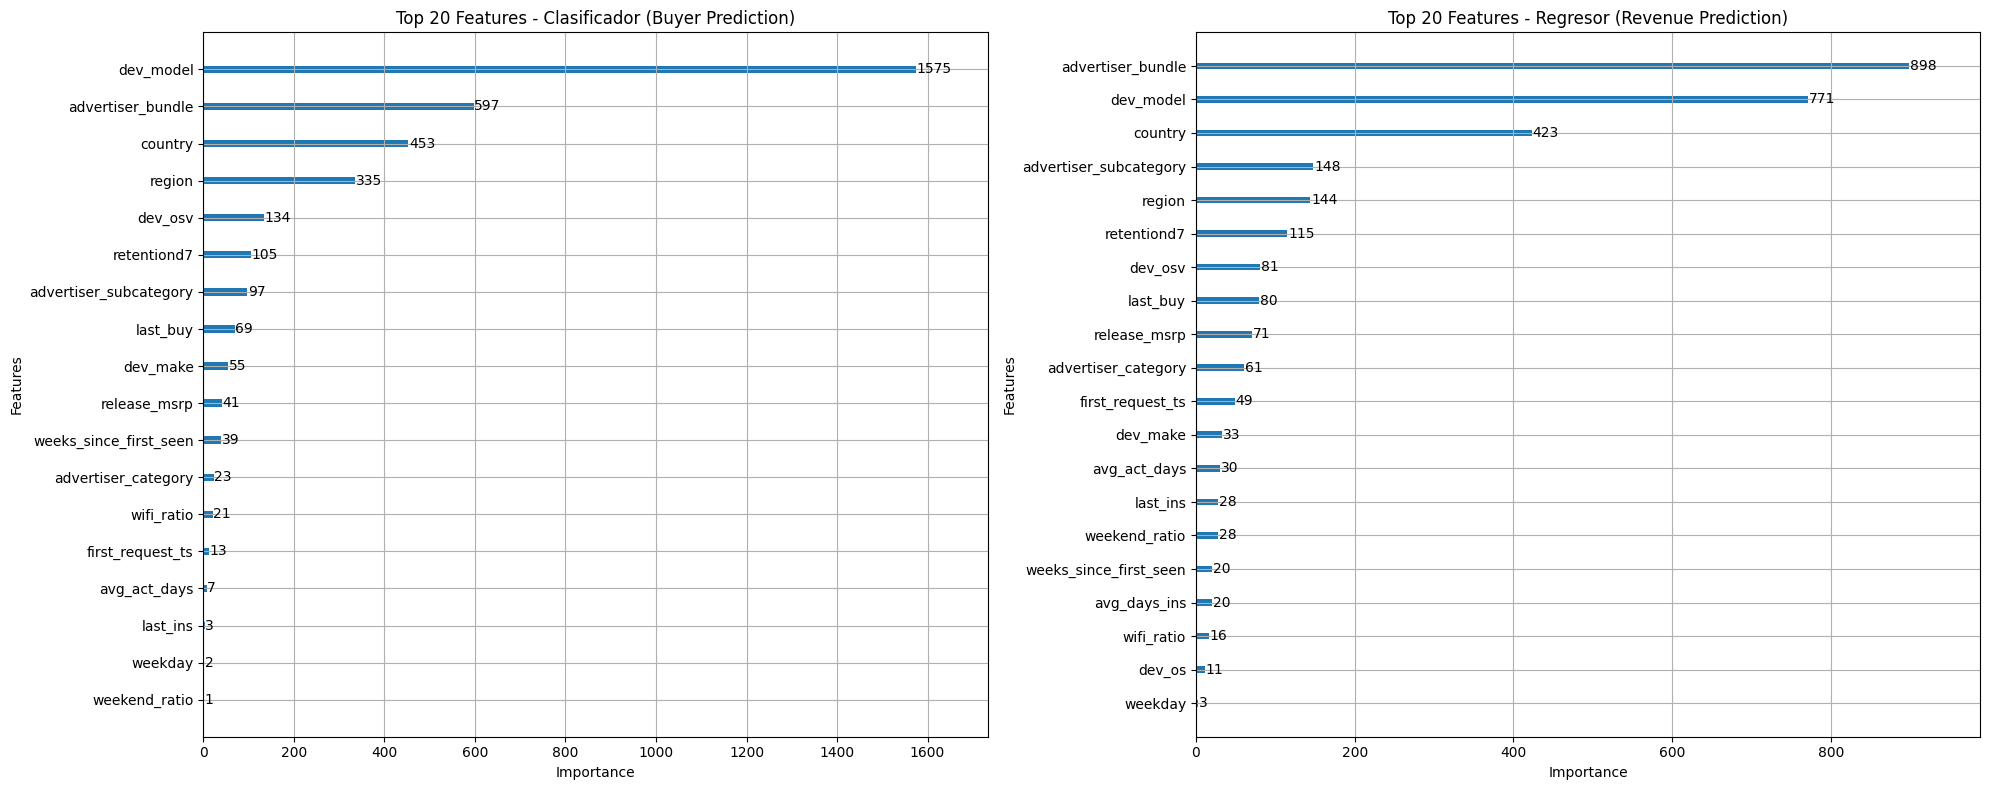

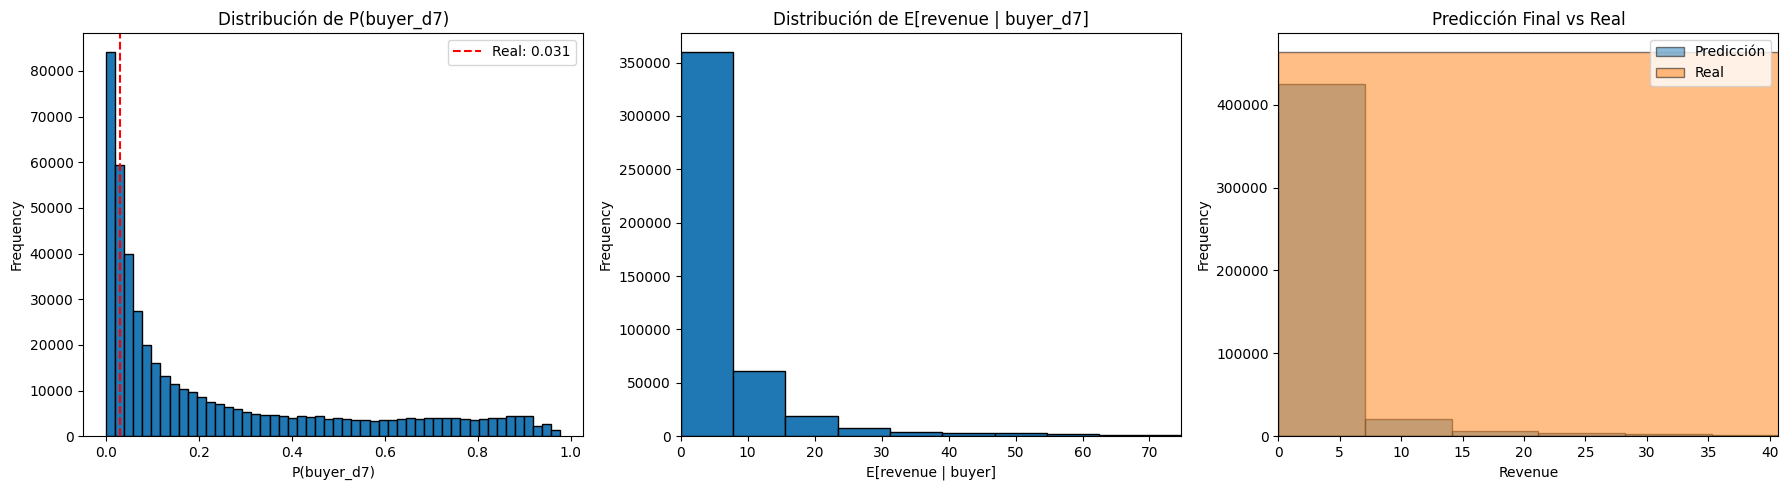

In [17]:
# Análisis de feature importance para ambos modelos
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Feature importance del clasificador
lgb.plot_importance(model_classifier, max_num_features=20, ax=axes[0], title='Top 20 Features - Clasificador (Buyer Prediction)')
axes[0].set_xlabel('Importance')

# Feature importance del regresor
lgb.plot_importance(model_regressor, max_num_features=20, ax=axes[1], title='Top 20 Features - Regresor (Revenue Prediction)')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.show()

# Análisis de distribución de predicciones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribución de probabilidad de buyer
axes[0].hist(prob_buyer_val, bins=50, edgecolor='black')
axes[0].set_xlabel('P(buyer_d7)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribución de P(buyer_d7)')
axes[0].axvline(y_val_buyer.mean(), color='r', linestyle='--', label=f'Real: {y_val_buyer.mean():.3f}')
axes[0].legend()

# Distribución de revenue dado buyer
axes[1].hist(revenue_given_buyer, bins=50, edgecolor='black')
axes[1].set_xlabel('E[revenue | buyer]')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribución de E[revenue | buyer_d7]')
axes[1].set_xlim(0, np.percentile(revenue_given_buyer, 99))

# Distribución de predicción final vs real
axes[2].hist(pred_val, bins=50, alpha=0.5, label='Predicción', edgecolor='black')
axes[2].hist(y_val, bins=50, alpha=0.5, label='Real', edgecolor='black')
axes[2].set_xlabel('Revenue')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Predicción Final vs Real')
axes[2].set_xlim(0, np.percentile(pred_val, 99))
axes[2].legend()

plt.tight_layout()
plt.show()


ANÁLISIS DE y_val (VALORES REALES DE REVENUE)

Estadísticas completas de y_val:
count    463601.000000
mean          1.425769
std         335.384672
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      227283.110000
Name: iap_revenue_d7, dtype: float64

Distribución de ceros:
  Valores = 0: 451,031 (97.29%)
  Valores > 0: 12,570 (2.71%)

Estadísticas SOLO para y_val > 0 (12570 valores):
count     12570.000000
mean         52.584573
std        2036.215334
min           0.000581
25%           2.369414
50%           8.020592
75%          21.734607
max      227283.110000
Name: iap_revenue_d7, dtype: float64

Valores mínimos (excluyendo 0):
  Min: 0.000581
  Percentil 1%: 0.039341
  Percentil 5%: 0.490000
  Percentil 10%: 0.919826


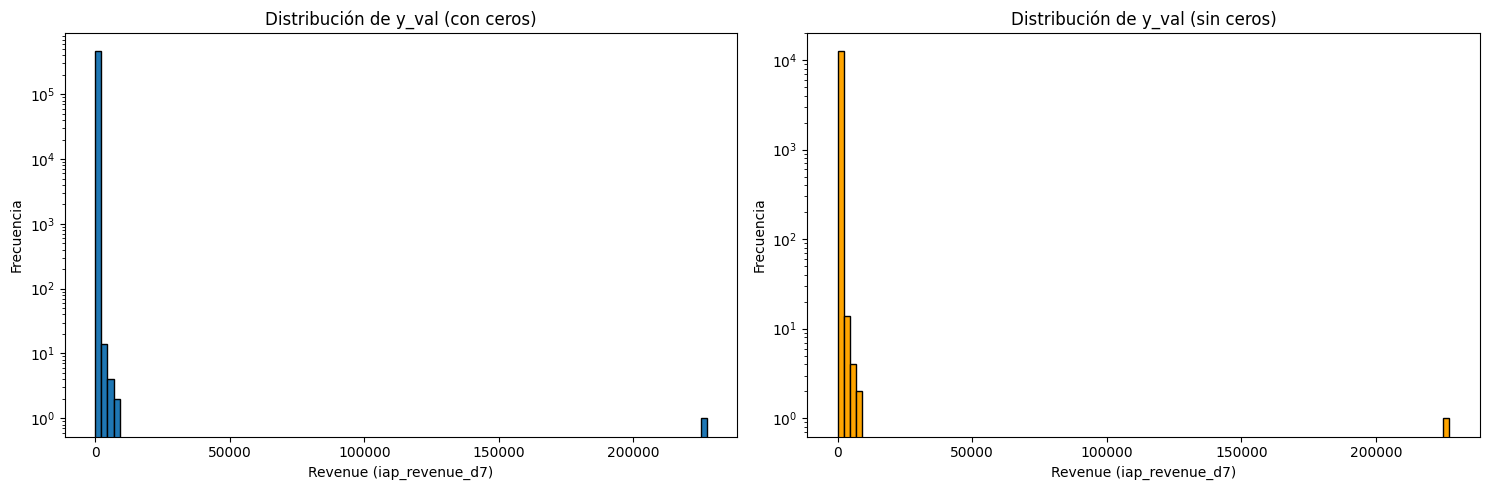

: 

In [ ]:
# Análisis de y_val (valores reales de revenue)
print("\n" + "=" * 60)
print("ANÁLISIS DE y_val (VALORES REALES DE REVENUE)")
print("=" * 60)

# Estadísticas generales
print(f"\nEstadísticas completas de y_val:")
print(y_val.describe())

# Análisis de ceros
n_zeros = (y_val == 0).sum()
n_nonzeros = (y_val > 0).sum()
pct_zeros = n_zeros / len(y_val) * 100

print(f"\nDistribución de ceros:")
print(f"  Valores = 0: {n_zeros:,} ({pct_zeros:.2f}%)")
print(f"  Valores > 0: {n_nonzeros:,} ({100-pct_zeros:.2f}%)")

# Análisis solo de valores > 0
y_val_nonzero = y_val[y_val > 0]
print(f"\nEstadísticas SOLO para y_val > 0 ({len(y_val_nonzero)} valores):")
print(y_val_nonzero.describe())

print(f"\nValores mínimos (excluyendo 0):")
print(f"  Min: {y_val_nonzero.min():.6f}")
print(f"  Percentil 1%: {y_val_nonzero.quantile(0.01):.6f}")
print(f"  Percentil 5%: {y_val_nonzero.quantile(0.05):.6f}")
print(f"  Percentil 10%: {y_val_nonzero.quantile(0.10):.6f}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma con todos los valores
axes[0].hist(y_val, bins=100, edgecolor='black')
axes[0].set_xlabel('Revenue (iap_revenue_d7)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de y_val (con ceros)')
axes[0].set_yscale('log')

# Histograma solo valores > 0
axes[1].hist(y_val_nonzero, bins=100, edgecolor='black', color='orange')
axes[1].set_xlabel('Revenue (iap_revenue_d7)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de y_val (sin ceros)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")

In [ ]:
# ============================================
# PREDICCIÓN EN TEST SET - TODAS LAS FILAS
# ============================================
print("=" * 60)
print("Generando predicciones para el test set (TODAS LAS FILAS)")
print("=" * 60)

# 1. Cargar TODOS los archivos de test (sin sampling)
parquet_files_test = glob(os.path.join(test_path, '**/part-*.parquet'), recursive=True)
print(f"Total archivos test encontrados: {len(parquet_files_test)}")

# Cargar columnas necesarias (sin targets que no existen en test)
test_columns = [col for col in required_columns if col not in ['buyer_d7', 'iap_revenue_d7']]

print("Cargando test con Dask...")
test_ddf = dd.read_parquet(parquet_files_test, engine='pyarrow')
print(f"✓ Test cargado: {len(test_ddf.columns)} columnas")

# 2. NO HACER COMPUTE TODAVÍA - Procesar por particiones
print("\nProcesando test por particiones para evitar problemas de memoria...")

# Función para preprocesar cada partición
def preprocess_partition(partition):
    """Preprocesa una partición del test"""
    # Label encoding para categorías
    for col in cat_features:
        if col in partition.columns and col in label_encoders:
            partition[col] = partition[col].astype(str).fillna("__NA__")
            le = label_encoders[col]
            # Manejar valores no vistos
            partition[col] = partition[col].map(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )
    
    # Asegurar que todas las features existen
    for f in features:
        if f not in partition.columns:
            partition[f] = 0
    
    # Seleccionar solo features del modelo
    X = partition[features].copy()
    
    # Convertir tipos
    for col in X.columns:
        if col not in cat_features and X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')
    
    X = X.fillna(0)
    
    for col in cat_features:
        if col in X.columns:
            X[col] = X[col].astype('category')
    
    return X, partition['row_id']

# 3. Procesar por chunks para no romper memoria
print("\nGenerando predicciones por chunks...")

predictions_list = []
row_ids_list = []
chunk_size = 100000  # Ajustar según memoria disponible

# Persistir en memoria distribuida
test_ddf = test_ddf.persist()

# Obtener número total de filas (aproximado)
total_rows = len(test_ddf)
print(f"Total filas a predecir: {total_rows:,}")

# Procesar por particiones
n_partitions = test_ddf.npartitions
print(f"Procesando {n_partitions} particiones...")

for i in range(n_partitions):
    print(f"  Procesando partición {i+1}/{n_partitions}...", end=' ')
    
    # Obtener partición
    partition = test_ddf.get_partition(i).compute()
    
    # Preprocesar
    X_partition, row_ids_partition = preprocess_partition(partition)
    
    # Predecir con modelo optimizado (best model del grid search)
    pred_log = model_best.predict(X_partition)
    pred = np.expm1(pred_log).clip(0, None)
    
    # Guardar resultados
    predictions_list.append(pred)
    row_ids_list.append(row_ids_partition.values)
    
    print(f"✓ ({len(pred):,} filas)")
    
    # Liberar memoria
    del partition, X_partition
    gc.collect()

# 4. Combinar todas las predicciones
print("\nCombinando predicciones...")
all_predictions = np.concatenate(predictions_list)
all_row_ids = np.concatenate(row_ids_list)

print(f"✓ Total predicciones generadas: {len(all_predictions):,}")

# 5. Crear submission
submission = pd.DataFrame({
    'row_id': all_row_ids,
    'iap_revenue_d7': all_predictions
})

# Verificar que tenemos todas las filas
print(f"\n{'='*60}")
print("VERIFICACIÓN DE SUBMISSION")
print(f"{'='*60}")
print(f"Total predicciones: {len(submission):,}")
print(f"Row IDs únicos: {submission['row_id'].nunique():,}")
print(f"Duplicados: {submission['row_id'].duplicated().sum()}")
print(f"NaN en predicciones: {submission['iap_revenue_d7'].isna().sum()}")
print(f"\nEstadísticas de predicciones:")
print(submission['iap_revenue_d7'].describe())

# 6. Guardar submission
submission_path = '/home/stargix/Desktop/hackathons/datathon/submission_complete.csv'
submission.to_csv(submission_path, index=False)
print(f"\n✓ Submission completo guardado en: {submission_path}")
print(f"✓ Archivo generado con {len(submission):,} filas")

Generando predicciones para el test set (TODAS LAS FILAS)
Total archivos test encontrados: 96
Cargando test con Dask...
✓ Test cargado: 68 columnas

Procesando test por particiones para evitar problemas de memoria...

Generando predicciones por chunks...
